## Introduction

In this project, we work on the Expedia Hotel Recommendation dataset. In this dataset, Expedia provides logs of customer behavior which include what customers searched for and how they interacted with search results (click/book). Our goal is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event. As the competition, the goal is not just to provide one cluster but to rank the predictions and return top 5 most likely hotel clusters out of 100 clusters for each event.

The problem can be modeled as a ranked multi-class classification task. Missing data and the curse of dimenionality are main challenge of this dataset. We apply multiple approachs for this problem, which include:
* Naive Bayes (for baseline method)
* KNN
* Random Forest
* Support Vector Machine

Also, note that there was a leak in the data during the contest. The leak affected approximately 30% of the test data. Expedia confirmed that one can find hotel cluster by matching the rows from the train dataset based one some columns: user_location_country, user_location_region, user_location_city, orig_desination_distance and hotel_market. However, predictions based on this will not be 100% accurate.


## Data descriptive

On the Kaggle site, the train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. The training set has ~37 mil entries and the test set contains 2.5 mil entries.

Since the result for the test set is not published, we just work on the train dataset. Moreover, we observe: 
* There are many users who search for the hotel without making any reservation (~92% of training set), 
* The purpose of the competition is predicting for the booking event

Therefore, we will use the booking only subset of the dataset (i.e. is_booking==1) for our analysis. So, the booking dataset we will work on has 3,000,693 entries. There are 2 set of features: 
1. The log search event of users (22 features) which provide information:
    * User info: location (city, country, region), user id 
    * Trip: destination (hotel continent, country, market), check in/out date, number of room, number of children/adults
    * Booking site: site name, continent of site name
2. The latent features (149 features) about destinations extracted from hotel review text on subjects relevant to hotel services such as cleanliness, attractions, etc. Those features can be mapped by srch_destination_id of search event feature set. 

Let take a closer look at the data to see the activities of customers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Load the dataset of booking event.
PATH= '/Users/Hrachya/Desktop/DATA/train.csv'
df= pd.read_csv(PATH)
df= df.loc[df['is_booking']==1]
df= df.drop(['is_booking'], axis=1)

In [2]:
#See the information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000693 entries, 1 to 37670292
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_time                  object 
 1   site_name                  int64  
 2   posa_continent             int64  
 3   user_location_country      int64  
 4   user_location_region       int64  
 5   user_location_city         int64  
 6   orig_destination_distance  float64
 7   user_id                    int64  
 8   is_mobile                  int64  
 9   is_package                 int64  
 10  channel                    int64  
 11  srch_ci                    object 
 12  srch_co                    object 
 13  srch_adults_cnt            int64  
 14  srch_children_cnt          int64  
 15  srch_rm_cnt                int64  
 16  srch_destination_id        int64  
 17  srch_destination_type_id   int64  
 18  cnt                        int64  
 19  hotel_continent            int64  
 20  h

In [3]:
#5 head data points
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,2,0,1,8250,1,1,2,50,628,1
20,2014-02-27 18:01:32,2,3,66,318,52078,NaN,756,0,1,...,2,0,1,8291,1,1,2,50,191,2
27,2013-06-15 15:38:05,30,4,195,548,56440,NaN,1048,0,1,...,2,0,1,1385,1,1,0,185,185,58
72,2014-11-23 18:02:20,30,4,195,991,47725,NaN,1048,0,0,...,2,0,1,8803,1,1,3,151,69,36
79,2014-01-03 16:30:17,2,3,66,462,41898,2454.8588,1482,0,1,...,3,0,2,12009,1,1,2,50,680,95


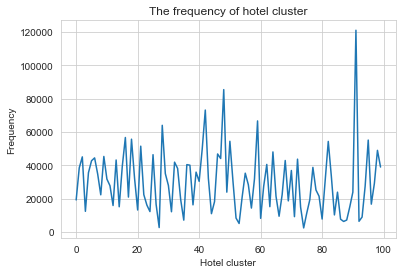

In [4]:
# The frequency for each hotel_clusters
clus_fre= [(df['hotel_cluster']==i).sum() for i in range(100)]
plt.plot(range(100),clus_fre)
plt.xlabel('Hotel cluster')
plt.ylabel('Frequency')
plt.title('The frequency of hotel cluster', fontsize=12)
plt.show()

<AxesSubplot:title={'center':'10 most frequency hotel clusters account for 22.9% '}, xlabel='Hotel cluster', ylabel='%'>

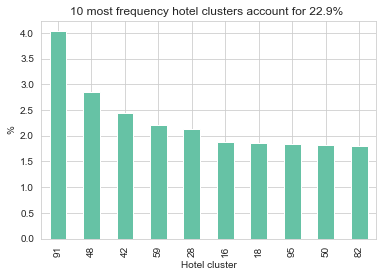

In [5]:
# Top 10 frequent hotel_clusters
s=(df["hotel_cluster"].value_counts()/df.shape[0]*100)[:10].sum()
((df["hotel_cluster"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'10 most frequency hotel clusters account for {s:3.3}% ',ylabel='%', xlabel='Hotel cluster', kind='bar',colormap="Set2",figsize=(6,4))

Customer location is presented by 3 freatures: 
* user_location_country: 235 countries
* user_location_region: 970 regions
* user_location_city: 36,917 cities

Notice that not each city or region just belongs to one country. For example, city == 56507 is in countries [61, 66, 69] or region 0 are in 35 different countries. 

In [6]:
#Number of cities
#len(df['user_location_city'].unique())

#Number of countries
#b=len(df['user_location_country'].unique()) 

#Number of regions
#c=len(df['user_location_region'].unique()) 

<AxesSubplot:title={'center':'Top 10 cities customers come from, 10.2% '}, xlabel='Cities', ylabel='%'>

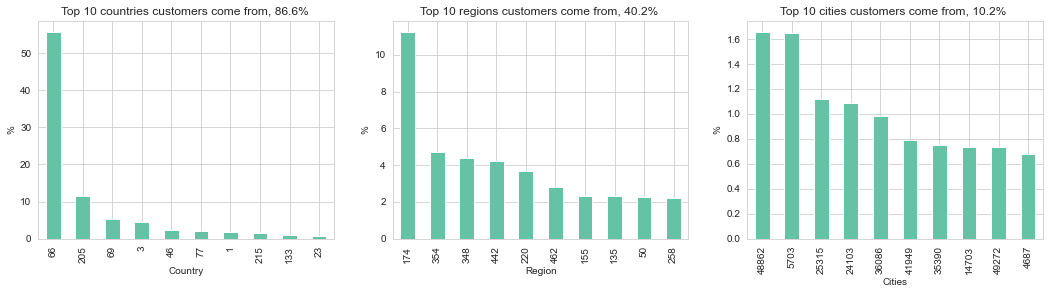

In [7]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(18,4))

# Top 10 countries customers come from
c=(df["user_location_country"].value_counts()/df.shape[0]*100)[:10].sum()
((df["user_location_country"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'Top 10 countries customers come from, {c:3.3}% ', ylabel='%', xlabel='Country', kind='bar', colormap="Set2",ax=axis1)

# Top 10 regions customers come from
c=(df["user_location_region"].value_counts()/df.shape[0]*100)[:10].sum()
((df["user_location_region"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'Top 10 regions customers come from, {c:3.3}% ', ylabel='%', xlabel='Region', kind='bar', colormap="Set2",ax=axis2)

# Top 10 cities customers come from
c=(df["user_location_city"].value_counts()/df.shape[0]*100)[:10].sum()
((df["user_location_city"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'Top 10 cities customers come from, {c:3.3}% ', ylabel='%', xlabel='Cities', kind='bar', colormap="Set2",ax=axis3)

Destination location is presented by 3 freatures: 
* hotel_continent: 7 continents
* hotel_country: 205 countries
* hotel_market: 2,103 markets 

In [8]:
#Number of hotel_continent 
#len(df['hotel_continent'].unique())
#Number of countries
#len(df['hotel_country'].unique()) 
#Number of markets
#len(df['hotel_market'].unique()) 

<AxesSubplot:title={'center':'Top 10 hotel market customers travel to, 20.4% '}, xlabel='Hotel market', ylabel='%'>

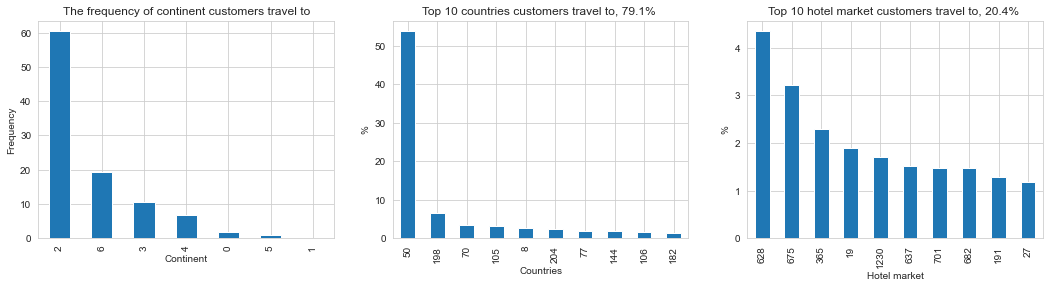

In [9]:
# Where customers travel to
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(18,4))
#Continents customer travel to 
((df["hotel_continent"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'The frequency of continent customers travel to',ylabel='Frequency',xlabel='Continent', kind='bar',ax= axis1)

# Top 10 counties customer travel to 
c=(df["hotel_country"].value_counts()/df.shape[0]*100)[:10].sum()
((df["hotel_country"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'Top 10 countries customers travel to, {c:3.3}% ',ylabel='%',xlabel='Countries', kind='bar',ax= axis2)

#Top 10 market customer travel to
# Top 10 counties customer travel to 
c=(df["hotel_market"].value_counts()/df.shape[0]*100)[:10].sum()
((df["hotel_market"].value_counts()/df.shape[0]*100)[:10]).plot(title= f'Top 10 hotel market customers travel to, {c:3.3}% ',ylabel='%',xlabel='Hotel market', kind='bar',ax= axis3)

Text(0.5, 1.0, 'Hotel cluster frequency of user_location_city =48862, hotel_market=628 ')

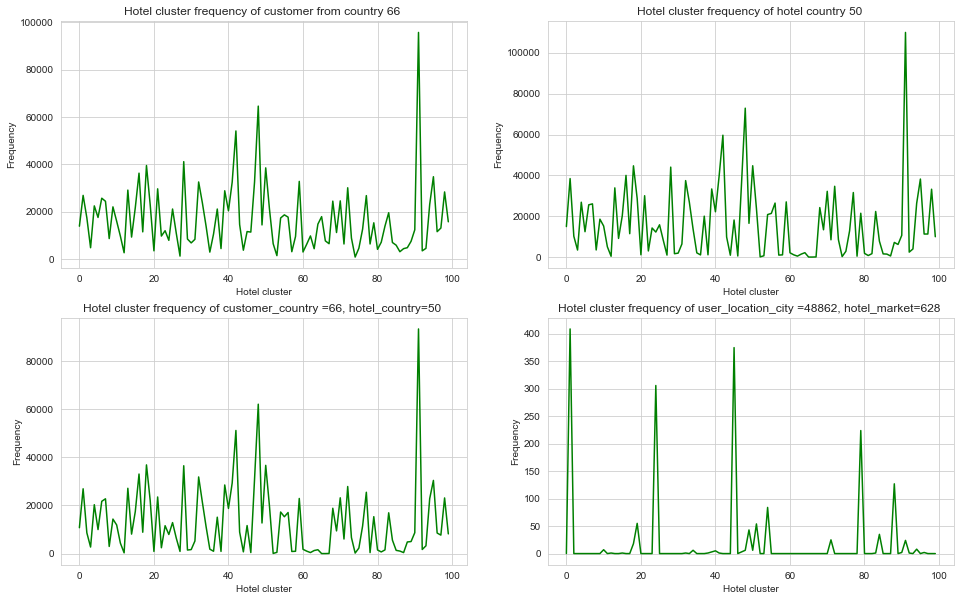

In [10]:
fig, ((axis1, axis2),(axis3,axis4)) = plt.subplots(2,2, figsize=(16,10))
#From the original country 66, which hotel clusters customers often chose
country=df[df['user_location_country']==66]
clus_fre6= [(country['hotel_cluster']==i).sum() for i in range(100)]
axis1.plot(range(100),clus_fre6, color= 'green',)
axis1.set_xlabel('Hotel cluster')
axis1.set_ylabel('Frequency')
axis1.set_title('Hotel cluster frequency of customer from country 66 ', fontsize=12)

#In destination country 50, which hotel culters are more common.
des50=df[df['hotel_country']==50]
clus_fre50= [(des50['hotel_cluster']==i).sum() for i in range(100)]
axis2.plot(range(100),clus_fre50,color='green')
axis2.set_xlabel('Hotel cluster')
axis2.set_ylabel('Frequency')
axis2.set_title('Hotel cluster frequency of hotel country 50 ', fontsize=12)

#In from country 66 to country 50, which hotel culters are more common.
des56=df[(df['hotel_country']==50) & (df['user_location_country']==66)]
clus_fre56= [(des56['hotel_cluster']==i).sum() for i in range(100)]
axis3.plot(range(100),clus_fre56,color='green')
axis3.set_xlabel('Hotel cluster')
axis3.set_ylabel('Frequency')
axis3.set_title('Hotel cluster frequency of customer_country =66, hotel_country=50 ', fontsize=12)

#In from city 48862 to market 628, which hotel culters are more common.
des=df[(df['hotel_market']==628) & (df['user_location_city']==48862)]
clus_fre_4= [(des['hotel_cluster']==i).sum() for i in range(100)]
axis4.plot(range(100),clus_fre_4,color='green')
axis4.set_xlabel('Hotel cluster')
axis4.set_ylabel('Frequency')
axis4.set_title('Hotel cluster frequency of user_location_city =48862, hotel_market=628 ', fontsize=12)

Text(0.5, 1.0, 'Number of adults frequency')

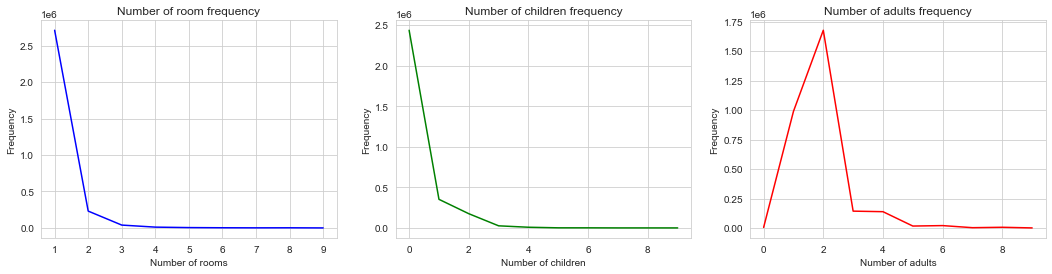

In [11]:
#Number of room, children, adults
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(18,4))

#Number of room 
room= [(df['srch_rm_cnt']==i).sum() for i in range(1,10)]
axis1.plot(range(1,10),room, color= 'blue',)
axis1.set_xlabel('Number of rooms')
axis1.set_ylabel('Frequency')
axis1.set_title('Number of room frequency', fontsize=12)

#Number of children
chil= [(df['srch_children_cnt']==i).sum() for i in range(10)]
axis2.plot(range(10),chil,color='green')
axis2.set_xlabel('Number of children')
axis2.set_ylabel('Frequency')
axis2.set_title('Number of children frequency', fontsize=12)

#Number of adults srch_adults_cnt
ad= [(df['srch_adults_cnt']==i).sum() for i in range(10)]
axis3.plot(range(10),ad,color='red')
axis3.set_xlabel('Number of adults')
axis3.set_ylabel('Frequency')
axis3.set_title('Number of adults frequency', fontsize=12)

<AxesSubplot:>

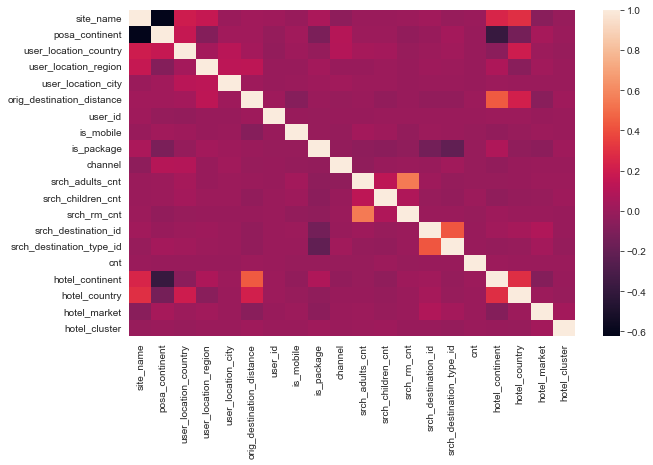

In [12]:
#Data correlation with target
corre= df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corre)

In [13]:
#Load the latent features from destination file
des='/Users/Hrachya/Desktop/DATA/destinations.csv'
dest= pd.read_csv(des)

In [14]:
dest.shape

(62106, 150)

In [15]:
#All the features here are numerical features
dest.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [16]:
#There is no missing data in the destination latent feature files
dest.isnull().sum().sum()

0

## Data Preprocessing

There are several works we do for preprecessing data:
* Date time data: Convert the date_time, srch_ci and srch_co to date time data, then add new columns for months from the date we got from checkin, checkout date. Then, we also add another column for duration of stay = checkout date - checkin date.
* Missing data: Fill the missing data of orig_destination_distance (~30% data). We will fill na by the median of group of customer come from the same city and travel to the same country. 
* Curse of dimension: Reduce the dimension for latent features using PCA.
* Categorical data: Create dummy variable for categorical features. For some features (user_location_city, hotel_country, etc) their number of class are huge (>1000), we will just create dummies for the majority class.

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [18]:
#Working on 1% sample ~ 30k lines 
df= df.sample(frac=0.01, random_state=99) 

In [19]:
#Convert date_time data types
df['srch_ci'] = pd.to_datetime(df['srch_ci'])
df['srch_co'] = pd.to_datetime(df['srch_co'])
df['date_time'] = pd.to_datetime(df['date_time'])

#Add trip duration
df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')

# For date_time log month
df['mon'] = df["date_time"].apply(lambda x: x.month)

# For hotel check-in month
df['ci_mon'] = df["srch_ci"].apply(lambda x: x.month)

# For hotel check-out month
df['co_mon'] = df["srch_co"].apply(lambda x: x.month)

#Drop all date-time features
df= df.drop(["date_time","srch_ci","srch_co"], axis=1)

In [20]:
df.shape

(30007, 24)

In [21]:
#check the missing value
#df.isnull().sum()

#fill the NA by the median value of group of user with the same 'user_location_city' and 'hotel_country'
median=df['orig_destination_distance'].median()
df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df.groupby(['user_location_city','hotel_country'])['orig_destination_distance'].transform('median'))

#Fill the rest NA by the median value of set
df['orig_destination_distance']=df['orig_destination_distance'].fillna(median)

In [22]:
df.isnull().sum().sum()

0

In [23]:
#####PCA for the latent features#######
dest.shape

(62106, 150)

In [24]:
df['srch_destination_id'].nunique()

5934

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Using srch_destination_id from search feature to map latent features
latent= df['srch_destination_id']
latent = pd.merge(latent, dest, how='left', on='srch_destination_id')

#latent.isnull().sum()
#Fill na by mean value then drop search_destination_id
latent.fillna(latent.mean(), inplace=True)
latent = latent.drop(["srch_destination_id"], axis=1)

In [26]:
#Scale data
latent=MinMaxScaler().fit_transform(latent)

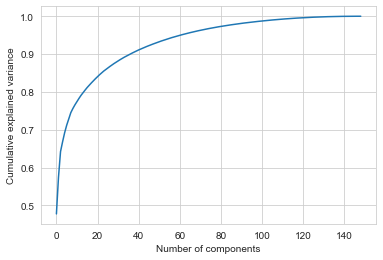

In [27]:
#Run PCA and check the variance on number of components to see how many component should be chose
pca=PCA()
L_pca=pca.fit_transform(latent)

pca.explained_variance_ratio_[::-1].sort()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [28]:
#Chose 40 components since 40 components give > 90% variance.
pca40=PCA(n_components=40)
L_pca= pca40.fit_transform(latent)

In [29]:
num_var=['orig_destination_distance','is_mobile', 'is_package','srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt','srch_destination_id','stay_dur']
cate_l=['hotel_country','hotel_market','site_name','user_location_city','user_location_country','user_location_region']
cate_s=['channel','ci_mon','cnt','co_mon','hotel_continent','mon','posa_continent','srch_destination_type_id']
y=['hotel_cluster']

In [30]:
#######Categorical features

In [31]:
cate_f= df.columns.difference(num_var+y)
d=[]
for i in cate_f:
    d.append([i,len(df[i].unique())])
cd = pd.DataFrame(d, columns = ["Feature", "Number of distinct value"])
print(cd)

                     Feature  Number of distinct value
0                    channel                        11
1                     ci_mon                        12
2                        cnt                         6
3                     co_mon                        12
4            hotel_continent                         7
5              hotel_country                       160
6               hotel_market                      1636
7                        mon                        12
8             posa_continent                         5
9                  site_name                        42
10  srch_destination_type_id                         8
11                   user_id                     28551
12        user_location_city                      6039
13     user_location_country                       170
14      user_location_region                       633


In [32]:
#Assign other to low frequency categories (<95%)
def lowFreq(i, df):
    freq=df[i].value_counts(normalize =True)
    bottom = freq.quantile(q=0.05)
    less_freq = freq[freq<=bottom]
    df.loc[df[i].isin(less_freq.index.tolist()),[i]] = -1

In [33]:
for i in cate_f:
    lowFreq(i, df)

In [34]:
d=[]
for i in cate_f:
    d.append([i,len(df[i].unique())])
cd = pd.DataFrame(d, columns = ["Feature", "Number of distinct value"])
print(cd)

                     Feature  Number of distinct value
0                    channel                        11
1                     ci_mon                        12
2                        cnt                         6
3                     co_mon                        12
4            hotel_continent                         7
5              hotel_country                       141
6               hotel_market                      1353
7                        mon                        12
8             posa_continent                         5
9                  site_name                        38
10  srch_destination_type_id                         8
11                   user_id                      1339
12        user_location_city                      2952
13     user_location_country                       133
14      user_location_region                       506


In [35]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [36]:
###Run PCA for group of large unique value groups
#Group hotel_country and hotel_market
X=df[['hotel_country','hotel_market']]
enc = OneHotEncoder()
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())

In [37]:
pca=PCA(n_components=0.8)
m_pca=pca.fit_transform(ohe_df)

In [38]:
m_pca.shape

(30007, 185)

In [39]:
#Site name
X=df[['site_name']]
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())
pca=PCA(n_components=0.8)
m_pca_site=pca.fit_transform(ohe_df)

In [40]:
#Group user_location_city, user_location_country and user_location_region
X=df[['user_location_city','user_location_country','user_location_region']]
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())

In [41]:
pca=PCA(n_components=0.8)
m_pca_user=pca.fit_transform(ohe_df)

In [42]:
#######Join all data to one dataFrame

In [43]:
X=df[num_var]

In [44]:
#Join pca_latent feature to df
col=['l'+str(i) for i in range(L_pca.shape[1])]
lat=pd.DataFrame(L_pca,index=df.index, columns=col)

In [45]:
X=X.join(lat)

In [46]:
#Join pca_hotel_country and hotel_market feature to df
col=['m'+str(i) for i in range(m_pca.shape[1])]
market=pd.DataFrame(m_pca,index=df.index,columns=col)

In [47]:
X=X.join(market)

In [48]:
#Join site name feature to df
col=['s'+str(i) for i in range(m_pca_site.shape[1])]
site=pd.DataFrame(m_pca_site,index=df.index,columns=col)

In [49]:
X=X.join(site)

In [50]:
#Join user location feature to df
col=['ul'+str(i) for i in range(m_pca_user.shape[1])]
user=pd.DataFrame(m_pca_user,index=df.index,columns=col)

In [51]:
X=X.join(user)

In [52]:
#Create dummies for small categorical features
dum=df[cate_s]
dum= pd.get_dummies(data= dum, columns= cate_s, drop_first=True)

In [53]:
X=X.join(dum)

In [54]:
###########Scale data
scaler = MinMaxScaler()
X= scaler.fit_transform(X)

In [55]:
#Final data for feature set
X.shape

(30007, 637)

In [56]:
#Target y- hotel cluster
y=df[y]

## Run machine learning techniques

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.naive_bayes as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

In [58]:
#####Split train, test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [59]:
#### Naive Bayes

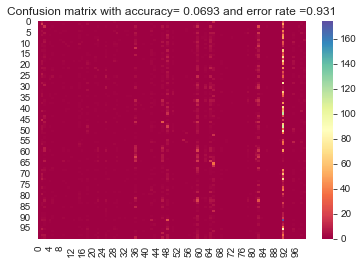

Categorical NB accuracy: predict 1 cluster is 0.0693, predict top 5 clusters is  0.125.


In [60]:
# Categorical NB
cnb = nb.CategoricalNB(min_categories=2)
model = cnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test) 
C = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sns.heatmap(C, cmap='Spectral')
plt.title(f"Confusion matrix with accuracy={accuracy: 3.3} and error rate ={1-accuracy:3.3}")
plt.show()

#Predict top 5 clusters
pred_prob= model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
accuracy2= s/len(y_test)
print(f'Categorical NB accuracy: predict 1 cluster is {accuracy:3.3}, predict top 5 clusters is {accuracy2: 3.3}.')

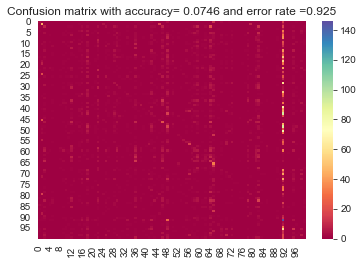

Multinomial NB model accuracy: predict 1 cluster is 0.0746, predict top 5 clusters is  0.136.


In [61]:
# Multinomial NB
mnb = nb.MultinomialNB()
model = mnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test) 
C = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sns.heatmap(C, cmap='Spectral')
plt.title(f"Confusion matrix with accuracy={accuracy: 3.3} and error rate ={1-accuracy:3.3}")
plt.show()

#Predict top 5 clusters
pred_prob= model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
accuracy2= s/len(y_test)
print(f'Multinomial NB model accuracy: predict 1 cluster is {accuracy:3.3}, predict top 5 clusters is {accuracy2: 3.3}.')

In [62]:
####### KNN

In [63]:
#Euclidean distance 
neigbor= [i for i in range(5,205,10)]
rfE=[]
for i in neigbor:
    knnM= KNeighborsClassifier(n_neighbors=i)
    x= np.mean(cross_val_score(knnM, X_train, y_train, cv=5, scoring='accuracy'))
    rfE.append(x)

In [64]:
#Mahattan distance
neigbor= [i for i in range(5,205,10)]
rfM=[]
for i in neigbor:
    knnM= KNeighborsClassifier(n_neighbors=i,p=1,n_jobs=-1)
    x= np.mean(cross_val_score(knnM, X_train, y_train, cv=5, scoring='accuracy'))
    rfM.append(x)

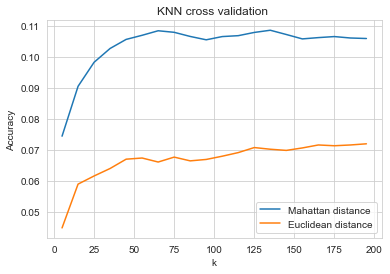

In [65]:
plt.plot(range(5,205,10), rfM, label = 'Mahattan distance')
plt.plot(range(5,205,10), rfE, label = 'Euclidean distance')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN cross validation ')
plt.legend()
plt.show()

In [66]:
print(f'Best number of k for Mahattan distance is {neigbor[rfM.index(max(rfM))]} with the CV accuracy is {max(rfM):3.3}')
print(f'Best number of k for Euclidean distance is {neigbor[rfE.index(max(rfE))]} with the CV accuracy is {max(rfE):3.3}')

Best number of k for Mahattan distance is 135 with the CV accuracy is 0.109
Best number of k for Euclidean distance is 195 with the CV accuracy is 0.072


In [67]:
k=neigbor[rfE.index(max(rfE))]
#Estimate model with best k for Euclidean distance
kM= KNeighborsClassifier(n_neighbors=k)
kM.fit(X_train, y_train)
y_pred= kM.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= kM.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'Euclidean KNN model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')

Euclidean KNN model accuracy: predict 1 cluster is 0.0758, predict top 5 clusters is  0.134.


In [68]:
k=neigbor[rfM.index(max(rfM))]
#Estimate model with best k for Euclidean distance
kM= KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=-1)
kM.fit(X_train, y_train)
y_pred= kM.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= kM.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'Mahattan KNN model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')

Mahattan KNN model accuracy: predict 1 cluster is 0.112, predict top 5 clusters is  0.188.


In [69]:
########Random Forest

In [70]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print('Model Performance')
    print(f"accuracy={accuracy: 3.3} and error rate ={1-accuracy:3.3}, oob score={model.oob_score_:3.3}")
    #Predict top 5 clusters
    pred_prob= model.predict_proba(X_test)
    pre5=[]
    for i in range(pred_prob.shape[0]):
        arr= pred_prob[i]
        pre5.append(arr.argsort()[-5:][::-1])
    ##Accuracy if we just predict 5 values
    s=0
    for i in range(len(y_test)):
        a=y_test.iloc[i]['hotel_cluster']
        x=list(pre5[i])
        if a in x:
            s+=1/(1+x.index(a))
    accuracy2= s/len(y_test)
    print(f'model accuracy: predict 1 cluster is {accuracy:3.3}, predict top 5 clusters is {accuracy2: 3.3}.')
    
    return accuracy2


In [71]:
#Base Random Forest Model
rf_base = RandomForestClassifier(n_estimators=100, min_samples_leaf=500, oob_score=True, n_jobs=-1)
rfmodel = rf_base.fit(X_train,y_train)
#y_pred = rfmodel.predict(X_test)
pred_prob = rfmodel.predict_proba(X_test)

base_accuracy= evaluate(rfmodel,X_test,y_test)

Model Performance
accuracy= 0.1 and error rate =0.9, oob score=0.102
model accuracy: predict 1 cluster is 0.1, predict top 5 clusters is  0.179.


In [72]:
#Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 30, stop = 500, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#oob score
oob_score =True
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }


In [73]:
rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=10, n_jobs = -1, scoring='accuracy')
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(oob_score=True),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'min_samples_leaf': [30, 82, 134, 186,
                                                             238, 291, 343, 395,
                                                             447, 500],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=10, scoring='accuracy', verbose=2)

In [74]:
print(f"best params: {rf_random.best_params_}, best score: {rf_random.best_score_:3.3}")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

best params: {'n_estimators': 600, 'min_samples_leaf': 30, 'bootstrap': True}, best score: 0.126
Model Performance
accuracy= 0.129 and error rate =0.871, oob score=0.132
model accuracy: predict 1 cluster is 0.129, predict top 5 clusters is  0.225.
Improvement of 25.66%.


In [75]:
####Suport Vector Machine 

In [76]:
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’},
svm_model=SVC(kernel="rbf", decision_function_shape='ovo', probability=True)
#svm_model=SVC(kernel="linear",probability=True)
#svm_model=SVC(kernel="rbf",probability=True)

svm_model.fit(X_train, y_train)

y_pred= svm_model.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= svm_model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'SVM model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')



SVM model accuracy: predict 1 cluster is 0.118, predict top 5 clusters is  0.205.


## Another Approach for Categorical with high cadinality of distinct value:

1. Use PCA with lower number of components to keep (i.e 50% variant instead of 80%). 
2. Encode number of frequence of cluster to be chose in each group of user_location, hotel_market, search_id that is suggested by Data Leak.  

In [77]:
#######Run PCA for lower variant = 0.5
#Group hotel_country and hotel_market
X=df[['hotel_country','hotel_market']]
enc = OneHotEncoder()
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())

In [78]:
pca=PCA(n_components=0.5)
m_pca=pca.fit_transform(ohe_df)

In [79]:
m_pca.shape

(30007, 30)

In [80]:
#Site name
X=df[['site_name']]
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())
pca=PCA(n_components=0.5)
m_pca_site=pca.fit_transform(ohe_df)

In [81]:
#Group user_location_city, user_location_country and user_location_region
X=df[['user_location_city','user_location_country','user_location_region']]
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())

In [82]:
pca=PCA(n_components=0.5)
m_pca_user=pca.fit_transform(ohe_df)

In [83]:
#PCA for small categorical features
X=df[cate_s]
trans = enc.fit_transform(X)
ohe_df = pd.DataFrame(trans.toarray())

In [84]:
pca=PCA(n_components=0.5)
dum=pca.fit_transform(ohe_df)

In [85]:
#######Join all data to one dataFrame

In [86]:
X=df[num_var]

In [87]:
#Join pca_latent feature to df
col=['l'+str(i) for i in range(L_pca.shape[1])]
lat=pd.DataFrame(L_pca,index=df.index, columns=col)

In [88]:
X=X.join(lat)

In [89]:
#Join pca_hotel_country and hotel_market feature to df
col=['m'+str(i) for i in range(m_pca.shape[1])]
market=pd.DataFrame(m_pca,index=df.index,columns=col)

In [90]:
X=X.join(market)

In [91]:
#Join site name feature to df
col=['s'+str(i) for i in range(m_pca_site.shape[1])]
site=pd.DataFrame(m_pca_site,index=df.index,columns=col)

In [92]:
X=X.join(site)

In [93]:
#Join user location feature to df
col=['ul'+str(i) for i in range(m_pca_user.shape[1])]
user=pd.DataFrame(m_pca_user,index=df.index,columns=col)

In [94]:
X=X.join(user)

In [95]:
#Join other categorical variables
col=['d'+str(i) for i in range(dum.shape[1])]
dum=pd.DataFrame(dum,index=df.index,columns=col)

In [96]:
X=X.join(dum)

In [97]:
X.shape

(30007, 124)

In [98]:
#####Create features for cluster frequency by ['user_location_city','srch_destination_id','hotel_country','hotel_market','hotel_cluster']

In [99]:
X=X.join(df[['hotel_country','hotel_market']])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [101]:
dic=X_train[['srch_destination_id']].join(df[['hotel_country','hotel_market','hotel_cluster']])

In [102]:
dic['num']=1

In [103]:
pieces = [dic.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['num'].agg(['sum'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

In [104]:
agg.head()

sum
srch_destination_id hotel_country hotel_market hotel_cluster     
8                   50            416          10               1
                                               32               1
                                               48               1
11                  50            824          42               1
                                               48               1

In [105]:
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)

In [106]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum').reset_index()

In [107]:
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,77,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
agg_pivot.shape

(5374, 103)

In [109]:
X_train = pd.merge(X_train, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [110]:
X_test = pd.merge(X_test, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [111]:
X_train.fillna(0, inplace=True)
X_test.fillna(0,inplace=True)

In [112]:
X_train.shape

(24005, 226)

In [113]:
scl=scaler.fit(X_train)

In [114]:
X_train=scl.transform(X_train)

In [115]:
X_test=scl.transform(X_test)

In [116]:
X_test.shape

(6002, 226)

In [117]:
#######Naive Bayes Model 

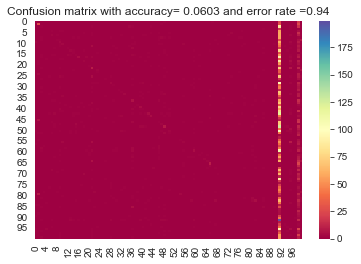

Categorical NB accuracy: predict 1 cluster is 0.0603, predict top 5 clusters is  0.0975.


In [118]:
# Categorical NB
cnb = nb.CategoricalNB(min_categories=2)
model = cnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test) 
C = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sns.heatmap(C, cmap='Spectral')
plt.title(f"Confusion matrix with accuracy={accuracy: 3.3} and error rate ={1-accuracy:3.3}")
plt.show()

#Predict top 5 clusters
pred_prob= model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
accuracy2= s/len(y_test)
print(f'Categorical NB accuracy: predict 1 cluster is {accuracy:3.3}, predict top 5 clusters is {accuracy2: 3.3}.')

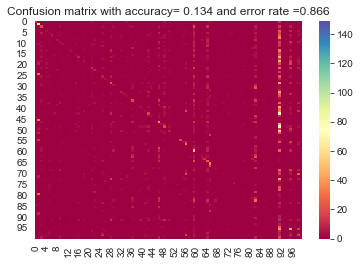

Multinomial NB model accuracy: predict 1 cluster is 0.134, predict top 5 clusters is  0.216.


In [119]:
# Multinomial NB
mnb = nb.MultinomialNB()
model = mnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test) 
C = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sns.heatmap(C, cmap='Spectral')
plt.title(f"Confusion matrix with accuracy={accuracy: 3.3} and error rate ={1-accuracy:3.3}")
plt.show()

#Predict top 5 clusters
pred_prob= model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
accuracy2= s/len(y_test)
print(f'Multinomial NB model accuracy: predict 1 cluster is {accuracy:3.3}, predict top 5 clusters is {accuracy2: 3.3}.')

In [120]:
###Random forest Model 

In [121]:
#Base Random Forest Model
rf_base = RandomForestClassifier(n_estimators=100, min_samples_leaf=500, oob_score=True, n_jobs=-1)
rfmodel = rf_base.fit(X_train,y_train)
#y_pred = rfmodel.predict(X_test)
pred_prob = rfmodel.predict_proba(X_test)

base_accuracy= evaluate(rfmodel,X_test,y_test)

Model Performance
accuracy= 0.118 and error rate =0.882, oob score=0.207
model accuracy: predict 1 cluster is 0.118, predict top 5 clusters is  0.203.


In [122]:
#Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 30, stop = 500, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#oob score
oob_score =True
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

In [123]:
rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=10, n_jobs = -1, scoring='accuracy')
rf_random.fit(X_train, y_train)
print(f"best params: {rf_random.best_params_}, best score: {rf_random.best_score_:3.3}")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best params: {'n_estimators': 1200, 'min_samples_leaf': 30, 'bootstrap': True}, best score: 0.311
Model Performance
accuracy= 0.147 and error rate =0.853, oob score=0.307
model accuracy: predict 1 cluster is 0.147, predict top 5 clusters is  0.244.
Improvement of 20.24%.


In [124]:
#####KNN Model 

In [125]:
#Euclidean distance
neigbor= [i for i in range(5,205,10)]
rfE=[]
for i in neigbor:
    knnM= KNeighborsClassifier(n_neighbors=i)
    x= np.mean(cross_val_score(knnM, X_train, y_train, cv=5, scoring='accuracy'))
    rfE.append(x)

In [126]:
#Mahattan distance
neigbor= [i for i in range(5,205,10)]
rfM=[]
for i in neigbor:
    knnM= KNeighborsClassifier(n_neighbors=i,p=1,n_jobs=-1)
    x= np.mean(cross_val_score(knnM, X_train, y_train, cv=5, scoring='accuracy'))
    rfM.append(x)

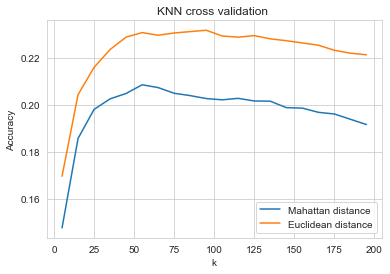

In [127]:
plt.plot(range(5,205,10), rfM, label = 'Mahattan distance')
plt.plot(range(5,205,10), rfE, label = 'Euclidean distance')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN cross validation ')
plt.legend()
plt.show()

In [128]:
print(f'Best number of k for Mahattan distance is {neigbor[rfM.index(max(rfM))]} with the CV accuracy is {max(rfM):3.3}')
print(f'Best number of k for Euclidean distance is {neigbor[rfE.index(max(rfE))]} with the CV accuracy is {max(rfE):3.3}')

Best number of k for Mahattan distance is 55 with the CV accuracy is 0.209
Best number of k for Euclidean distance is 95 with the CV accuracy is 0.232


In [129]:
k=neigbor[rfE.index(max(rfE))]
#Estimate model with best k for Euclidean distance
kM= KNeighborsClassifier(n_neighbors=k)
kM.fit(X_train, y_train)
y_pred= kM.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= kM.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'Euclidean KNN model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')

Euclidean KNN model accuracy: predict 1 cluster is 0.119, predict top 5 clusters is  0.196.


In [130]:
k=neigbor[rfM.index(max(rfM))]
#Estimate model with best k for Euclidean distance
kM= KNeighborsClassifier(n_neighbors=k, p=1, n_jobs=-1)
kM.fit(X_train, y_train)
y_pred= kM.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= kM.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'Mahattan KNN model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')

Mahattan KNN model accuracy: predict 1 cluster is 0.126, predict top 5 clusters is  0.214.


In [131]:
#### SVM

In [132]:
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’},
svm_model=SVC(kernel="rbf", decision_function_shape='ovo', probability=True)
#svm_model=SVC(kernel="linear",probability=True)
#svm_model=SVC(kernel="rbf",probability=True)

svm_model.fit(X_train, y_train)

y_pred= svm_model.predict(X_test)
C= confusion_matrix(y_test, y_pred)

#Accuracy if we just predict 1 value
acc1= sum(np.diag(C))/C.sum()

#Predict top 5 clusters
pred_prob= svm_model.predict_proba(X_test)
pre5=[]
for i in range(pred_prob.shape[0]):
    arr= pred_prob[i]
    pre5.append(arr.argsort()[-5:][::-1])
##Accuracy if we just predict 5 values
s=0
for i in range(len(y_test)):
    a=y_test.iloc[i]['hotel_cluster']
    x=list(pre5[i])
    if a in x:
        s+=1/(1+x.index(a))
acc2= s/len(y_test)
print(f'SVM model accuracy: predict 1 cluster is {acc1:3.3}, predict top 5 clusters is {acc2: 3.3}.')


SVM model accuracy: predict 1 cluster is 0.139, predict top 5 clusters is  0.231.
